In [2]:
# import libraries
%matplotlib inline
import pandas as pd
import numpy as np
import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn.functional as F
import torch.optim as optim
import torch.nn as nn
import matplotlib.pyplot as plt
import time
import warnings
warnings.filterwarnings('ignore')

In [34]:
# get dataloaders
batch_size = 20

transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=False, transform=transform)
validset = torchvision.datasets.CIFAR10(root='./data', train=False, download=False, transform=transform)

train_loader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=True, num_workers=2)
valid_loader = torch.utils.data.DataLoader(validset, batch_size=batch_size, shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

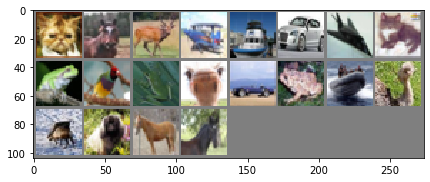

  cat horse  deer plane


In [36]:
# show some images
def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.figure(figsize=(7, 5))
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

# get some random training images
dataiter = iter(train_loader)
images, labels = dataiter.next()

# show images
imshow(torchvision.utils.make_grid(images))
# print labels
print(' '.join('%5s' % classes[labels[j]] for j in range(4)))

In [5]:
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        
        self.conv1 = nn.Conv2d(3, 16, 3, padding=1)
        self.conv2 = nn.Conv2d(16, 32, 3, padding=1)
        self.conv3 = nn.Conv2d(32, 64, 3, padding=1)
        
        # Pooling layers
        self.pool = nn.MaxPool2d(2,2)
        
        # Linear layer (64x4x4 -> 500)
        self.fc1 = nn.Linear(64 * 4 * 4, 500)
        
        # Linear Layer (500 -> 10)
        self.fc2 = nn.Linear(500, 10)
        
        # Dropout layer
        self.dropout = nn.Dropout(0.25)
        
    def forward(self, x):
        x = self.pool(F.elu(self.conv1(x)))
        x = self.pool(F.elu(self.conv2(x)))
        x = self.pool(F.elu(self.conv3(x)))
        
        # Flatten the image
        x = x.view(-1, 64*4*4)
        x = self.dropout(x)
        x = F.elu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        return x

In [6]:
def plot_accuracy(model_PATH, img_PATH):
    
    train_accuracy_list = torch.load(model_PATH)['train_accuracy_list']
    valid_accuracy_list = torch.load(model_PATH)['valid_accuracy_list']
    plt.plot(train_accuracy_list, label='Training Accuracy')
    plt.plot(valid_accuracy_list, label='Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend(loc='best')
    plt.title('Accuracy vs. Epochs')
    plt.savefig(img_PATH)
    plt.show()

In [7]:
def plot_losses(model_PATH, img_PATH):
    
    train_loss_list = torch.load(model_PATH)['train_loss_list']
    valid_loss_list = torch.load(model_PATH)['valid_loss_list']
    plt.plot(train_loss_list, label='Training loss')
    plt.plot(valid_loss_list, label='Validation loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss per batch')
    plt.legend(loc='best')
    plt.title('Losses vs. Epochs')
    plt.savefig(img_PATH)
    plt.show()

In [8]:
def plot_comparison(model_list, plot_train=True, start=0, figsize =(8, 5.5)):
    plt.figure(figsize=figsize)
    if plot_train:
        for model in model_list:
            loss = torch.load(model)['train_loss_list']
            plt.plot(loss[start:], label = model[7:-4])
        plt.title('Training loss vs. num of epochs')
    else:
        for model in model_list:
            loss = torch.load(model)['valid_loss_list']
            plt.plot(loss[start:], label = model[7:-4])
        plt.title('Validation loss vs. num of epochs')
    plt.xlabel('num of epochs')
    plt.ylabel('loss per batch')
    plt.legend(loc='best')
    plt.show()

In [9]:
def plot_acc_comparison(model_list, plot_train=True, start=0, figsize =(8, 5.5)):
    plt.figure(figsize=figsize)
    if plot_train:
        for model in model_list:
            loss = torch.load(model)['train_accuracy_list']
            plt.plot(loss[start:], label = model[7:-4])
        plt.title('Training accuracy vs. num of epochs')
    else:
        for model in model_list:
            loss = torch.load(model)['valid_accuracy_list']
            plt.plot(loss[start:], label = model[7:-4])
        plt.title('Validation accuracy vs. num of epochs')
    plt.xlabel('num of epochs')
    plt.ylabel('accuracy')
    plt.legend(loc='best')
    plt.show()

### General update

In [10]:
def train(model, PATH, lr_seq=[], num_epochs=25, rate=0.01, 
         by_epoch=False, by_cutoff=False, by_oscillate=False):
    
    train_loss_list = []
    valid_loss_list = [0.0, 0.0]
    train_accuracy_list = []
    valid_accuracy_list = []
    lr_seq.reverse()
    start_time = time.time()
    for epoch in range(num_epochs):
        train_loss = 0.0
        train_accuracy = 0.0
        for images, labels in train_loader:
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            
            train_loss += loss.item()
            train_accuracy += (outputs.max(dim=1)[1] == labels).type(torch.FloatTensor).mean().item()
        train_loss = train_loss/len(train_loader)
        train_loss_list.append(train_loss)
        train_accuracy = train_accuracy/len(train_loader)
        train_accuracy_list.append(train_accuracy)
        
        model.eval()
        with torch.no_grad():
            valid_loss = 0.0
            valid_accuracy = 0.0
            for images, labels in valid_loader:
                outputs = model(images)
                loss = criterion(outputs, labels)
                
                valid_loss += loss.item()
                valid_accuracy += (outputs.max(dim=1)[1] == labels).type(torch.FloatTensor).mean().item()
            valid_loss = valid_loss/len(valid_loader)
            valid_loss_list.append(valid_loss)
            valid_accuracy = valid_accuracy/len(valid_loader)
            valid_accuracy_list.append(valid_accuracy)
        
        print('epoch %5d   train loss: %.5f, train accuracy: %.5f, valid loss: %.5f, valid accuracy: %.5f' % 
              (epoch+1, train_loss, train_accuracy, valid_loss, valid_accuracy))
         
        if abs(valid_loss_list[-1] - valid_loss_list[-3]) < 1e-7:
            print('Model converges!')
            end_time = time.time()
            converge_time = end_time - start_time
            print("Running time is %g seconds" % (converge_time))
            valid_loss_list = valid_loss_list[2:]
            torch.save({'epoch': (epoch+1), 'model_state_dict': model.state_dict(), 
                'optimizer_state_dict': optimizer.state_dict(), 
               'train_loss_list': train_loss_list, 
                'valid_loss_list': valid_loss_list, 
                'train_accuracy_list': train_accuracy_list,
               'valid_accuracy_list': valid_accuracy_list, 
               'converge_time': converge_time}, PATH)  
            break
        
        if by_epoch:
            lr = lr_seq.pop()
            print('Update learning rate! New learning rate is: %.6f'% lr)
            for param_group in optimizer.param_groups:
                param_group['lr'] = lr
        
        if by_cutoff:
            if abs(valid_loss_list[-1] - valid_loss_list[-2]) < valid_loss_list[2]*rate:
                lr = lr_seq.pop()
                print('Update learning rate! New learning rate is: %.6f'% lr)
                rate = rate * 0.2
                for param_group in optimizer.param_groups:
                    param_group['lr'] = lr
        
        if by_oscillate:
            if valid_loss_list[-1] > valid_loss_list[-2]:
                lr = lr_seq.pop()
                print('Update learning rate! New learning rate is: %.6f'% lr)
                for param_group in optimizer.param_groups:
                    param_group['lr'] = lr
        
    end_time = time.time()
    converge_time = end_time - start_time
    print("Running time is %g seconds" % (converge_time))
    valid_loss_list = valid_loss_list[2:]
    torch.save({'epoch': (epoch+1), 'model_state_dict': model.state_dict(), 
                'optimizer_state_dict': optimizer.state_dict(), 
               'train_loss_list': train_loss_list, 
                'valid_loss_list': valid_loss_list, 
                'train_accuracy_list': train_accuracy_list,
               'valid_accuracy_list': valid_accuracy_list, 
               'converge_time': converge_time}, PATH)   
    return model, train_loss_list, valid_loss_list, train_accuracy_list, valid_accuracy_list, converge_time      

### Benchmark

In [27]:
# parameters
learning_rate = 0.01
num_epochs = 25
lr_seq = []
PATH = 'models/cifar/benchmark-001.pth'

cnnnet = CNN()
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(cnnnet.parameters(), lr=learning_rate, momentum=0.9)
model, train_loss_list, valid_loss_list, train_accuracy_list, valid_accuracy_list, converge_time = train(cnnnet, PATH=PATH, lr_seq=lr_seq , num_epochs=num_epochs)     

epoch     1   train loss: 1.43893, train accuracy: 0.48482, valid loss: 1.19064, valid accuracy: 0.57070
epoch     2   train loss: 1.04278, train accuracy: 0.63652, valid loss: 0.97470, valid accuracy: 0.67160
epoch     3   train loss: 0.92687, train accuracy: 0.68232, valid loss: 1.03157, valid accuracy: 0.65790
epoch     4   train loss: 0.87601, train accuracy: 0.71018, valid loss: 1.08516, valid accuracy: 0.66740
epoch     5   train loss: 0.87178, train accuracy: 0.72328, valid loss: 1.05624, valid accuracy: 0.66600
epoch     6   train loss: 0.93096, train accuracy: 0.72266, valid loss: 1.61067, valid accuracy: 0.57470
epoch     7   train loss: 1.07101, train accuracy: 0.70348, valid loss: 1.42198, valid accuracy: 0.61770
epoch     8   train loss: 1.17853, train accuracy: 0.68864, valid loss: 1.55011, valid accuracy: 0.65780
epoch     9   train loss: 1.28013, train accuracy: 0.67856, valid loss: 1.53959, valid accuracy: 0.59620
epoch    10   train loss: 1.41004, train accuracy: 0.65

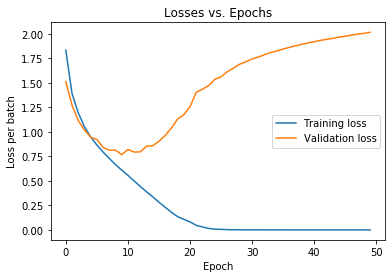

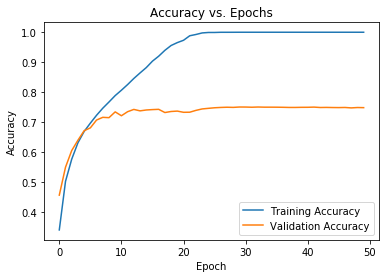

In [17]:
# plot loss for benchmark
plot_losses('models/cifar/benchmark-001.pth', 'images/cifar/benchmark-SGD.png')
plot_accuracy('models/cifar/benchmark-001.pth', 'images/cifar/benchmark-SGD-acc.png')

### Sequence 1

[1/2, 1/3, 1/4, ...]

In [14]:
## update by epoch

# parameters
learning_rate = 0.01
num_epochs = 25
lr_seq = [1 / x * learning_rate for x in range(2, 60)]
PATH = 'models/cifar/seq1-epoch.pth'

cnnnet = CNN()
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(cnnnet.parameters(), lr=learning_rate, momentum=0.9)
model, train_loss_list, valid_loss_list, train_accuracy_list, valid_accuracy_list, converge_time = train(cnnnet, PATH=PATH, lr_seq=lr_seq , num_epochs=num_epochs, by_epoch=True)     

epoch     1   train loss: 1.43802, train accuracy: 0.48832, valid loss: 1.17220, valid accuracy: 0.59400
Update learning rate! New learning rate is: 0.005000
epoch     2   train loss: 0.91792, train accuracy: 0.67548, valid loss: 0.88355, valid accuracy: 0.69320
Update learning rate! New learning rate is: 0.003333
epoch     3   train loss: 0.71393, train accuracy: 0.75096, valid loss: 0.81194, valid accuracy: 0.71930
Update learning rate! New learning rate is: 0.002500
epoch     4   train loss: 0.58234, train accuracy: 0.79588, valid loss: 0.76029, valid accuracy: 0.74760
Update learning rate! New learning rate is: 0.002000
epoch     5   train loss: 0.47867, train accuracy: 0.83260, valid loss: 0.75911, valid accuracy: 0.75350
Update learning rate! New learning rate is: 0.001667
epoch     6   train loss: 0.39098, train accuracy: 0.86232, valid loss: 0.78472, valid accuracy: 0.75330
Update learning rate! New learning rate is: 0.001429
epoch     7   train loss: 0.31063, train accuracy: 0

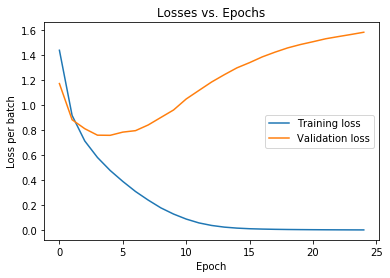

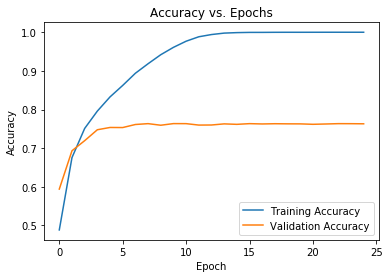

In [16]:
# plot loss for seq 1 by epoch
plot_losses('models/cifar/seq1-epoch.pth', 'images/cifar/seq1-epoch.png')
plot_accuracy('models/cifar/seq1-epoch.pth', 'images/cifar/seq1-epoch-acc.png')

In [19]:
## update by cutoff

# parameters
learning_rate = 0.01
num_epochs = 25
lr_seq = [1 / x * learning_rate for x in range(2, 60)]
PATH = 'models/cifar/seq1-cutoff.pth'

cnnnet = CNN()
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(cnnnet.parameters(), lr=learning_rate, momentum=0.9)
model, train_loss_list, valid_loss_list, train_accuracy_list, valid_accuracy_list, converge_time = train(cnnnet, PATH=PATH, lr_seq=lr_seq , num_epochs=num_epochs, by_cutoff=True, rate=0.1)     

epoch     1   train loss: 1.43022, train accuracy: 0.48940, valid loss: 1.16717, valid accuracy: 0.59080
epoch     2   train loss: 1.04916, train accuracy: 0.63294, valid loss: 0.99182, valid accuracy: 0.65580
epoch     3   train loss: 0.91490, train accuracy: 0.68970, valid loss: 1.00202, valid accuracy: 0.66210
Update learning rate! New learning rate is: 0.005000
epoch     4   train loss: 0.60620, train accuracy: 0.78922, valid loss: 0.78413, valid accuracy: 0.74500
epoch     5   train loss: 0.49511, train accuracy: 0.82628, valid loss: 0.87585, valid accuracy: 0.73420
epoch     6   train loss: 0.41406, train accuracy: 0.85368, valid loss: 0.90111, valid accuracy: 0.73000
epoch     7   train loss: 0.33422, train accuracy: 0.88224, valid loss: 0.98641, valid accuracy: 0.74000
epoch     8   train loss: 0.28072, train accuracy: 0.90230, valid loss: 1.22397, valid accuracy: 0.71810
epoch     9   train loss: 0.24296, train accuracy: 0.91674, valid loss: 1.16358, valid accuracy: 0.73080
ep

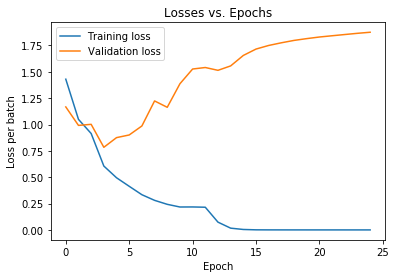

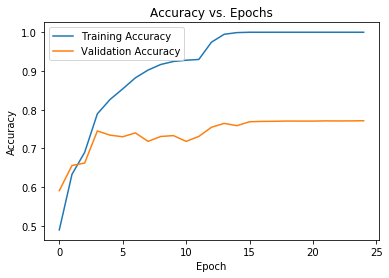

In [20]:
# plot loss for seq 1 by cutoff
plot_losses('models/cifar/seq1-cutoff.pth', 'images/cifar/seq1-cutoff.png')
plot_accuracy('models/cifar/seq1-cutoff.pth', 'images/cifar/seq1-cutoff-acc.png')

In [21]:
## update by oscillate

# parameters
learning_rate = 0.01
num_epochs = 25
lr_seq = [1 / x * learning_rate for x in range(2, 60)]
PATH = 'models/cifar/seq1-oscillate.pth'

cnnnet = CNN()
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(cnnnet.parameters(), lr=learning_rate, momentum=0.9)
model, train_loss_list, valid_loss_list, train_accuracy_list, valid_accuracy_list, converge_time = train(cnnnet, PATH=PATH, lr_seq=lr_seq , num_epochs=num_epochs, by_oscillate=True)     

epoch     1   train loss: 1.43638, train accuracy: 0.48386, valid loss: 1.18713, valid accuracy: 0.58520
Update learning rate! New learning rate is: 0.005000
epoch     2   train loss: 0.92093, train accuracy: 0.67816, valid loss: 0.91518, valid accuracy: 0.67740
epoch     3   train loss: 0.78149, train accuracy: 0.72512, valid loss: 0.85153, valid accuracy: 0.70360
epoch     4   train loss: 0.67234, train accuracy: 0.76558, valid loss: 0.82299, valid accuracy: 0.72580
epoch     5   train loss: 0.57769, train accuracy: 0.79696, valid loss: 0.80710, valid accuracy: 0.72950
epoch     6   train loss: 0.49069, train accuracy: 0.82872, valid loss: 0.87686, valid accuracy: 0.72850
Update learning rate! New learning rate is: 0.003333
epoch     7   train loss: 0.28630, train accuracy: 0.89954, valid loss: 0.89387, valid accuracy: 0.75280
Update learning rate! New learning rate is: 0.002500
epoch     8   train loss: 0.14828, train accuracy: 0.94872, valid loss: 0.98323, valid accuracy: 0.75690
U

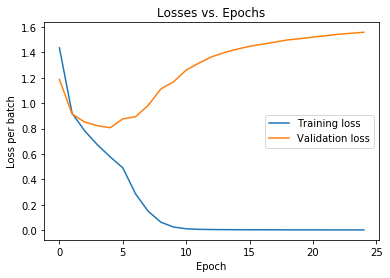

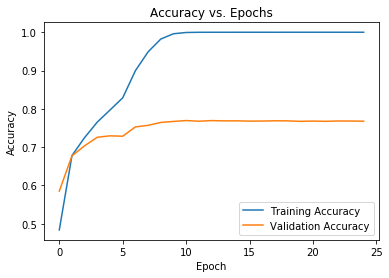

In [22]:
# plot loss for seq 1 by oscillate
plot_losses('models/cifar/seq1-oscillate.pth', 'images/cifar/seq1-oscillate.png')
plot_accuracy('models/cifar/seq1-oscillate.pth', 'images/cifar/seq1-oscillate-acc.png')

### Sequence 2
[1/sqrt(2), 1/sqrt(3), ...]

In [15]:
## update by epoch

# parameters
learning_rate = 0.01
num_epochs = 25
lr_seq = [1 / (x**0.5) * learning_rate for x in range(2, 60)]
PATH = 'models/cifar/seq2-epoch.pth'

cnnnet = CNN()
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(cnnnet.parameters(), lr=learning_rate, momentum=0.9)
model, train_loss_list, valid_loss_list, train_accuracy_list, valid_accuracy_list, converge_time = train(cnnnet, PATH=PATH, lr_seq=lr_seq , num_epochs=num_epochs, by_epoch=True)     

epoch     1   train loss: 1.70698, train accuracy: 0.36916, valid loss: 1.43627, valid accuracy: 0.49161
Update learning rate! New learning rate is: 0.007071
epoch     2   train loss: 1.31612, train accuracy: 0.53005, valid loss: 1.25427, valid accuracy: 0.55831
Update learning rate! New learning rate is: 0.005774
epoch     3   train loss: 1.16957, train accuracy: 0.58455, valid loss: 1.17809, valid accuracy: 0.58187
Update learning rate! New learning rate is: 0.005000
epoch     4   train loss: 1.06822, train accuracy: 0.61982, valid loss: 1.13041, valid accuracy: 0.59864
Update learning rate! New learning rate is: 0.004472
epoch     5   train loss: 0.99358, train accuracy: 0.64691, valid loss: 1.11064, valid accuracy: 0.61362
Update learning rate! New learning rate is: 0.004082
epoch     6   train loss: 0.92982, train accuracy: 0.66897, valid loss: 1.10655, valid accuracy: 0.61891
Update learning rate! New learning rate is: 0.003780
epoch     7   train loss: 0.87313, train accuracy: 0

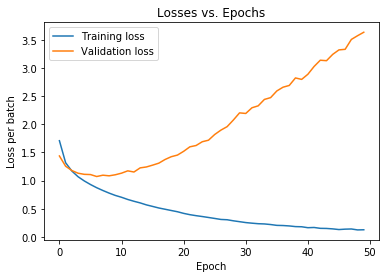

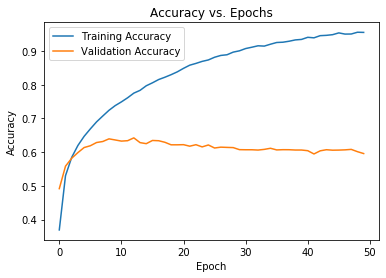

In [25]:
# plot loss for seq2 epoch
plot_losses('models/cifar/seq2-epoch.pth', 'images/cifar/seq2-epoch.png')
plot_accuracy('models/cifar/seq2-epoch.pth', 'images/cifar/seq2-epoch-acc.png')

In [27]:
## update by cutoff

# parameters
learning_rate = 0.01
num_epochs = 25
lr_seq = [1 / (x**0.5) * learning_rate for x in range(2, 60)]
PATH = 'models/cifar/seq2-cutoff.pth'

cnnnet = CNN()
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(cnnnet.parameters(), lr=learning_rate, momentum=0.9)
model, train_loss_list, valid_loss_list, train_accuracy_list, valid_accuracy_list, converge_time = train(cnnnet, PATH=PATH, lr_seq=lr_seq , num_epochs=num_epochs, by_cutoff=True)     

epoch     1   train loss: 1.70578, train accuracy: 0.37098, valid loss: 1.38411, valid accuracy: 0.50050
epoch     2   train loss: 1.31689, train accuracy: 0.52779, valid loss: 1.28755, valid accuracy: 0.54263
epoch     3   train loss: 1.17552, train accuracy: 0.57957, valid loss: 1.25536, valid accuracy: 0.55561
epoch     4   train loss: 1.08675, train accuracy: 0.61340, valid loss: 1.13739, valid accuracy: 0.60214
epoch     5   train loss: 1.02540, train accuracy: 0.63588, valid loss: 1.18295, valid accuracy: 0.59265
epoch     6   train loss: 0.97885, train accuracy: 0.65451, valid loss: 1.09555, valid accuracy: 0.61861
epoch     7   train loss: 0.93660, train accuracy: 0.66899, valid loss: 1.20333, valid accuracy: 0.59275
epoch     8   train loss: 0.89669, train accuracy: 0.68144, valid loss: 1.13955, valid accuracy: 0.61791
epoch     9   train loss: 0.86688, train accuracy: 0.69302, valid loss: 1.18707, valid accuracy: 0.61591
epoch    10   train loss: 0.84560, train accuracy: 0.70

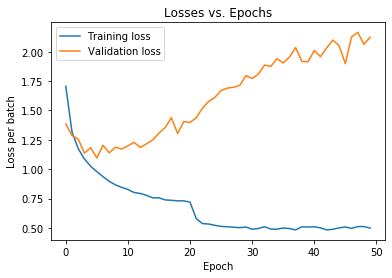

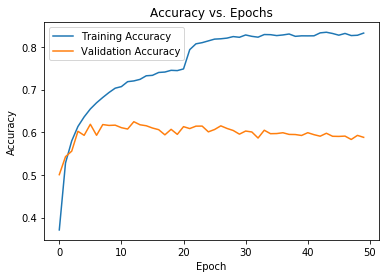

In [28]:
# plot loss for seq2 cutoff
plot_losses('models/cifar/seq2-cutoff.pth', 'images/cifar/seq2-cutoff.png')
plot_accuracy('models/cifar/seq2-cutoff.pth', 'images/cifar/seq2-cutoff-acc.png')

In [ ]:
## update by oscillate

# parameters
learning_rate = 0.01
num_epochs = 25
lr_seq = [1 / (x**0.5) * learning_rate for x in range(2, 60)]
PATH = 'models/cifar/seq2-oscillate.pth'

cnnnet = CNN()
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(cnnnet.parameters(), lr=learning_rate, momentum=0.9)
model, train_loss_list, valid_loss_list, train_accuracy_list, valid_accuracy_list, converge_time = train(cnnnet, PATH=PATH, lr_seq=lr_seq , num_epochs=num_epochs, by_oscillate=True)     

epoch     1   train loss: 1.74158, train accuracy: 0.35469, valid loss: 1.43814, valid accuracy: 0.48053
Update learning rate! New learning rate is: 0.007071
epoch     2   train loss: 1.32095, train accuracy: 0.52225, valid loss: 1.31302, valid accuracy: 0.53155
epoch     3   train loss: 1.18567, train accuracy: 0.57877, valid loss: 1.15884, valid accuracy: 0.58367
epoch     4   train loss: 1.09864, train accuracy: 0.60917, valid loss: 1.10185, valid accuracy: 0.61232
epoch     5   train loss: 1.03246, train accuracy: 0.63538, valid loss: 1.12474, valid accuracy: 0.60603
Update learning rate! New learning rate is: 0.005774
epoch     6   train loss: 0.94078, train accuracy: 0.67021, valid loss: 1.09400, valid accuracy: 0.62131
epoch     7   train loss: 0.89614, train accuracy: 0.68362, valid loss: 1.08750, valid accuracy: 0.62700
epoch     8   train loss: 0.85867, train accuracy: 0.69382, valid loss: 1.09766, valid accuracy: 0.62959
Update learning rate! New learning rate is: 0.005000
e

In [ ]:
# plot loss for seq2 oscillate
plot_losses('models/cifar/seq2-oscillate.pth', 'images/cifar/seq2-oscillate.png')
plot_accuracy('models/cifar/seq2-oscillate.pth', 'images/cifar/seq2-oscillate-acc.png')

### Adam

In [23]:
# parameters
learning_rate = 0.001
num_epochs = 25
lr_seq = []
PATH = 'models/cifar/benchmark-Adam.pth'

cnnnet = CNN()
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(cnnnet.parameters(), lr=learning_rate)
model, train_loss_list, valid_loss_list, train_accuracy_list, valid_accuracy_list, converge_time = train(cnnnet, PATH=PATH, lr_seq=lr_seq , num_epochs=num_epochs)     

epoch     1   train loss: 1.31339, train accuracy: 0.53308, valid loss: 1.04377, valid accuracy: 0.63070
epoch     2   train loss: 0.94526, train accuracy: 0.66926, valid loss: 0.93859, valid accuracy: 0.67120
epoch     3   train loss: 0.76797, train accuracy: 0.72976, valid loss: 0.86998, valid accuracy: 0.70190
epoch     4   train loss: 0.62205, train accuracy: 0.78264, valid loss: 0.81852, valid accuracy: 0.73100
epoch     5   train loss: 0.48946, train accuracy: 0.82874, valid loss: 0.87450, valid accuracy: 0.73560
epoch     6   train loss: 0.37150, train accuracy: 0.87046, valid loss: 0.93960, valid accuracy: 0.73290
epoch     7   train loss: 0.27390, train accuracy: 0.90430, valid loss: 1.10117, valid accuracy: 0.73660
epoch     8   train loss: 0.22048, train accuracy: 0.92440, valid loss: 1.22973, valid accuracy: 0.73060
epoch     9   train loss: 0.17514, train accuracy: 0.94006, valid loss: 1.43430, valid accuracy: 0.73040
epoch    10   train loss: 0.15992, train accuracy: 0.94

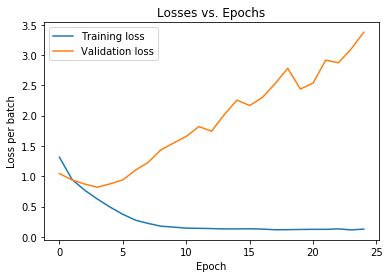

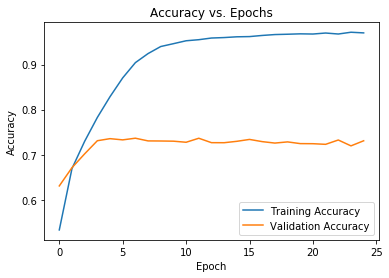

In [24]:
# plot loss for benchmark Adam
plot_losses('models/cifar/benchmark-Adam.pth', 'images/cifar/benchmark-Adam.png')
plot_accuracy('models/cifar/benchmark-Adam.pth', 'images/cifar/benchmark-Adam-acc.png')